In [147]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.io
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [148]:
imagesPerCategory = 1000


In [149]:
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using {device} device")

Using mps device


In [150]:
rockImages = np.empty((imagesPerCategory, 3, 300, 300))
paperImages = np.empty((imagesPerCategory, 3, 300, 300))
scissorImages = np.empty((imagesPerCategory, 3, 300, 300))
trainImages = np.empty((2700, 3, 300, 300))
testImages = np.empty((300, 3, 300, 300))
trainLabels = np.empty((2700))
testLabels = np.empty((300))
i = 0
files = os.listdir("images/rock/")
for f in files:
    filePath = os.path.join("images/rock/", f)
    if os.path.isfile(filePath):
        rockImages[i, :, :, :] = np.float32(torchvision.io.read_image(filePath))/255
        i += 1
np.random.shuffle(rockImages)
trainImages[:900, :, :, :] = rockImages[:900, :, :, :]
testImages[:100, :, :, :] = rockImages[900:1000, :, :, :]
trainLabels[:900] = 0
testLabels[:100] = 0

i = 0
files = os.listdir("images/paper/")
for f in files:
    filePath = os.path.join("images/paper/", f)
    if os.path.isfile(filePath):
        paperImages[i, :, :, :] = np.float32(torchvision.io.read_image(filePath))/255
        i += 1
np.random.shuffle(paperImages)
trainImages[900:1800, :, :, :] = paperImages[:900, :, :, :]
testImages[100:200, :, :, :] = paperImages[900:1000, :, :, :]
trainLabels[900:1800] = 1
testLabels[100:200] = 1

i = 0
files = os.listdir("images/scissors/")
for f in files:
    filePath = os.path.join("images/scissors/", f)
    if os.path.isfile(filePath):
        scissorImages[i, :, :, :] = np.float32(torchvision.io.read_image(filePath))/255
        i += 1
np.random.shuffle(scissorImages)
trainImages[1800:2700, :, :, :] = scissorImages[:900, :, :, :]
testImages[200:300, :, :, :] = scissorImages[900:1000, :, :, :]
trainLabels[1800:2700] = 2
testLabels[200:300] = 2


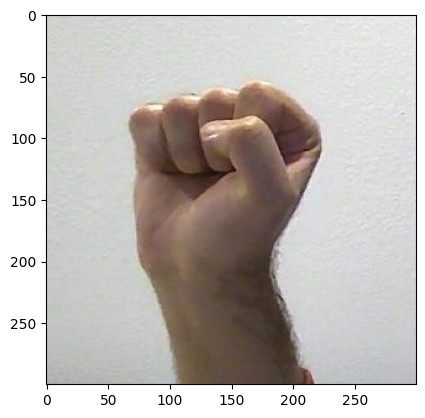

In [151]:
plt.imshow(np.transpose(trainImages[480, :, :, :], (1, 2, 0)))

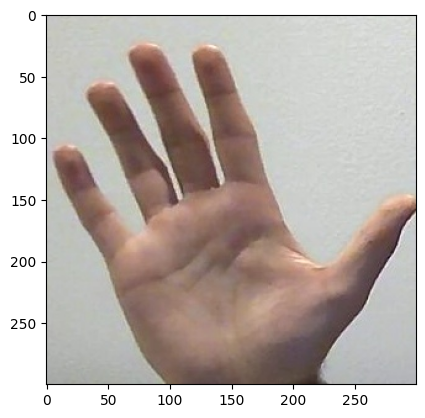

In [152]:
plt.imshow(np.transpose(testImages[125, :, :, :], (1, 2, 0)))

In [153]:
shuffler = np.random.permutation(len(trainLabels))
trainImages = trainImages[shuffler]
trainLabels = trainLabels[shuffler]

2.0


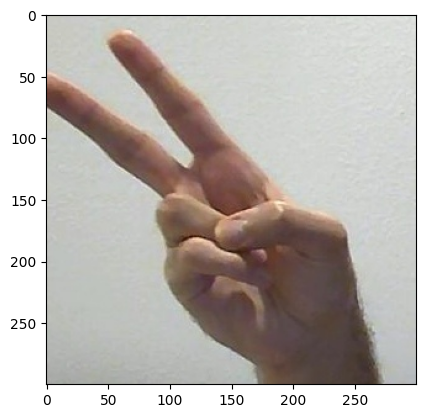

In [154]:
plt.imshow(np.transpose(trainImages[3, :, :, :], (1, 2, 0)))
print(trainLabels[3])

In [155]:
shuffler = np.random.permutation(len(testLabels))
testImages = testImages[shuffler]
testLabels = testLabels[shuffler]

0.0


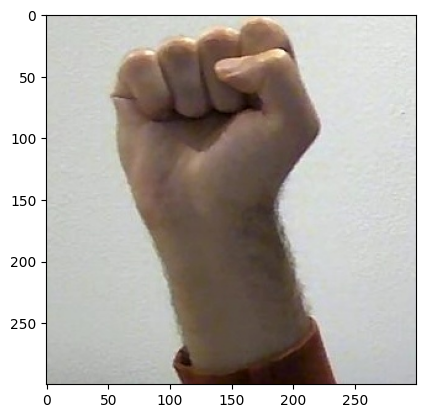

In [156]:
plt.imshow(np.transpose(testImages[4, :, :, :], (1, 2, 0)))
print(testLabels[4])

In [157]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convLayer1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=12, stride=4)
        self.maxPool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.convLayer2 = nn.Conv2d(in_channels=96, out_channels=256, padding=1, kernel_size=6, stride=1)
        self.maxPool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.convLayer3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=4, stride=1)
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(6*6*384, 4096)
        self.FC2 = nn.Linear(4096, 3)
        self.dropout = nn.Dropout()
        

    def forward(self, x):
        x = F.relu(self.convLayer1(x))
        x = self.maxPool1(x)
        x = F.relu(self.convLayer2(x))
        x = self.maxPool2(x)
        x = F.relu(self.convLayer3(x))
        x = self.maxPool3(x)
        x = F.relu(self.FC1(self.flatten(x)))
        x = self.dropout(x)
        x = self.FC2(x)
        return x

net = Net().to(device)
print(net)

Net(
  (convLayer1): Conv2d(3, 96, kernel_size=(12, 12), stride=(4, 4))
  (maxPool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convLayer2): Conv2d(96, 256, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (maxPool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convLayer3): Conv2d(256, 384, kernel_size=(4, 4), stride=(1, 1))
  (maxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=13824, out_features=4096, bias=True)
  (FC2): Linear(in_features=4096, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [158]:
def train(data, labels, net: nn.Module):
    lossFunction = nn.CrossEntropyLoss()
    lossList = []
    accuracyList = []
    epochs = 10
    batchSize = 50
    optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
    optimizer.zero_grad()

    for _ in tqdm(range(epochs)):
        for batchNumber in range(int(len(data) / batchSize)):
            start = batchNumber * batchSize
            currentData = data[start:start+batchSize, :, :, :]
            currentLabels = labels[start:start+batchSize]
            inputData = torch.FloatTensor(currentData).to(device)
            inputData.requires_grad_()
            outputData = torch.LongTensor(currentLabels).to(device)

            currentPredictions = net(inputData)

            currentLoss = lossFunction(currentPredictions, outputData)

            currentLoss.backward()

            optimizer.step()

            optimizer.zero_grad()

            lossList.append(currentLoss.item())

            accuracyList.append((currentPredictions.argmax(1) == outputData).type(torch.float).sum().item() / batchSize)
    
    return lossList, accuracyList

            

100%|██████████| 10/10 [04:45<00:00, 28.53s/it]


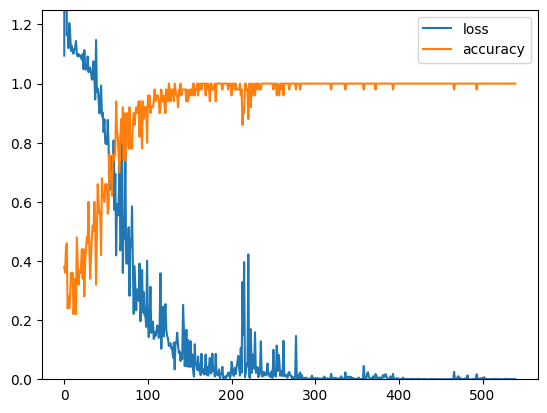

In [159]:
lossList, accList = train(trainImages, trainLabels, net)
plt.plot(range(len(lossList)), lossList, range(len(accList)), accList)
plt.legend(['loss', 'accuracy'])
plt.ylim((0,1.25))
plt.show()

In [160]:
def test(testData, testLabels, net):
    net.eval()
    batchSize = 25
    correct = 0
    with torch.no_grad():
        for batchNumber in range(int(len(testData) / batchSize)):
            start = batchNumber * batchSize

            currentData = testData[start:start+batchSize, :, :, :]

            currentData = torch.FloatTensor(currentData).to(device)

            currentLabels = testLabels[start:start+batchSize]
            currentLabels = torch.LongTensor(currentLabels).to(device)
            
            prediction = net(currentData)

            correct += (prediction.argmax(1) == currentLabels).type(torch.float).sum().item()
    return correct / len(testLabels)
            

In [161]:
print("Accuracy:", str(test(testImages, testLabels, net)))

Accuracy: 1.0


In [162]:
net_script = torch.jit.script(net)
net_script.save("hand_classifier.pt")